<img title="GitHub Octocat" src='./img/Octocat.jpg' style='height: 60px; padding-right: 15px' alt="Octocat" align="left"> This notebook is part of a GitHub repository: https://github.com/pessini/moby-bikes 
<br>MIT Licensed
<br>Author: Leandro Pessini

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from patsy import dmatrices

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# Model and Evaluation
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics

# statsmodel
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from typing import Type

# spicy
from scipy.stats import skew
from scipy.stats import boxcox
from scipy.stats import yeojohnson

import warnings
warnings.filterwarnings('ignore')

In [2]:
%reload_ext watermark
%watermark -a "Leandro Pessini" -n -u -v -iv -w

Author: Leandro Pessini

Last updated: Tue May 17 2022

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 8.3.0

numpy      : 1.21.1
sys        : 3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:36:15) 
[Clang 11.1.0 ]
seaborn    : 0.11.1
pandas     : 1.3.0
sklearn    : 1.0.2
statsmodels: 0.13.2
matplotlib : 3.4.2

Watermark: 2.3.0



In [3]:
hourly_rentals = pd.read_csv('../data/processed/df_train.csv')
hourly_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rain                8760 non-null   float64
 1   temp                8760 non-null   float64
 2   rhum                8760 non-null   int64  
 3   wdsp                8760 non-null   int64  
 4   date                8760 non-null   object 
 5   hour                8760 non-null   int64  
 6   day                 8760 non-null   int64  
 7   month               8760 non-null   int64  
 8   year                8760 non-null   int64  
 9   count               8760 non-null   int64  
 10  holiday             8760 non-null   bool   
 11  dayofweek_n         8760 non-null   int64  
 12  dayofweek           8760 non-null   object 
 13  working_day         8760 non-null   bool   
 14  season              8760 non-null   object 
 15  peak                8760 non-null   bool   
 16  timeso

## OLS Assumptions

In [12]:
expr = \
     """ count ~ C(rainfall_intensity) + C(temp_bin) + C(rhum_bin) + C(wind_speed_group) + holiday + working_day + peak + C(timesofday)"""
y_train, X_train = dmatrices(expr, hourly_rentals, return_type = 'dataframe')
# nb_training_results = sm.GLM(y_train, X_train, family = sm.families.NegativeBinomial(alpha = 1)).fit(maxiter=5000, method='nm', cov_type='HC3')
X_with_constant = sm.add_constant(X_train)
model = sm.GLM(y_train, X_with_constant).fit(cov_type='HC3')
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                 8760
Model:                            GLM   Df Residuals:                     8732
Model Family:                Gaussian   Df Model:                           27
Link Function:               identity   Scale:                          7.9395
Method:                          IRLS   Log-Likelihood:                -21491.
Date:                Tue, 17 May 2022   Deviance:                       69328.
Time:                        22:27:43   Pearson chi2:                 6.93e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4727
Covariance Type:                  HC3                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [ ]:
model.resid_working

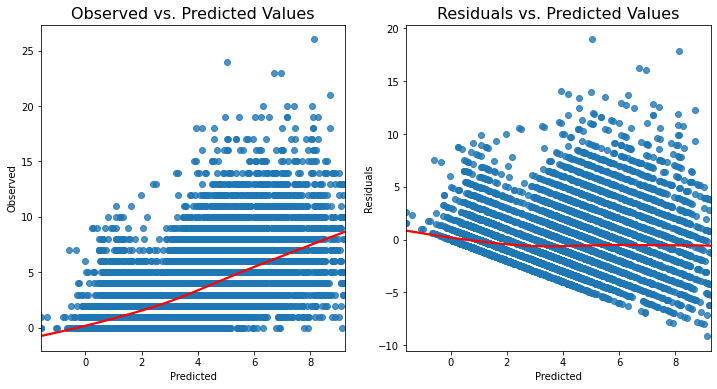

In [14]:
def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid_response

    fig, ax = plt.subplots(1,2, figsize=(12,6))
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')
    
linearity_test(model, y_train)   

In [ ]:
#create instance of influence
influence = model.get_influence()
#obtain standardized residuals
standardized_residuals = influence.resid_studentized_internal

In [ ]:
p = sns.distplot(model.resid,kde=True)
p = plt.title('Normality of error terms/residuals')

In [ ]:
model.resid.mean()

In [ ]:
X_test = X_test['temp_r']
y_test = np.log(y_test)
X_test_with_constant = sm.add_constant(X_test)
y_pred = model.predict(X_test_with_constant)
residuals = y_test - y_pred
# predicted_values = model.predict()
ols_residuals = model.resid

### Assumption 1 - Linearity

This assumes that there is a linear relationship between the predictors and the response variable.

<!-- > "In statistics, a regression model is linear when all terms in the model are either the constant or a parameter multiplied by an independent variable." (Frost, 2020, p. 202)
Frost, J. (2020). Regression Analysis: An Intuitive Guide for Using and Interpreting Linear Models. Statistics By Jim Publishing. -->


In [ ]:
#create instance of influence
influence = model.get_influence()
#obtain standardized residuals
standardized_residuals = influence.resid_studentized_internal
#display standardized residuals
print(standardized_residuals)

### Residuals x Temperature

In [ ]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.regplot(x=ols_residuals, y=model.fittedvalues, ax=ax, line_kws={'color': 'black', 'lw': 2, 'linestyle': '--'})
ax.set_title('Residuals vs. Temperature', fontsize=16)
ax.set(xlabel='Temperature', ylabel='Residuals')
plt.show()

In [ ]:
from sklearn.preprocessing import PowerTransformer
p = PowerTransformer(method = 'yeo-johnson')
y_train_tranformed = p.fit_transform(y_train.to_frame())

In [ ]:
vif = [variance_inflation_factor(X_with_constant.values, i) for i in range(X_with_constant.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=X.columns)

In [ ]:
fig = plt.figure(figsize=(16,12))
gs = fig.add_gridspec(2, 2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

sns.histplot(hourly_rentals['temp'],ax=ax0, stat='density', kde=True, 
             label= 'Skew :{0}'.format(np.round(skew(hourly_rentals['temp']),4)))
sns.histplot(hourly_rentals['rhum'],ax=ax1, stat='density', kde=True, 
             label= 'Skew :{0}'.format(np.round(skew(hourly_rentals['rhum']),4)))
sns.histplot(hourly_rentals['wdsp'],ax=ax2, stat='density', kde=True, 
             label= 'Skew :{0}'.format(np.round(skew(hourly_rentals['wdsp']),4)))
sns.histplot(hourly_rentals['count'],ax=ax3, stat='density', kde=True, 
             label= 'Skew :{0}'.format(np.round(skew(hourly_rentals['count']),4)))

ax0.set(xlabel='Temperature',title="Distribution - Temperature")
ax1.set(xlabel='Relative Humidity',title="Distribution - Relative Humidity")
ax2.set(xlabel='Wind Speed',title="Distribution - Wind Speed")
ax3.set(xlabel='Count', title="Distribution - Rentals Count")
ax0.legend(), ax1.legend(), ax2.legend(), ax3.legend()
plt.show()

In [ ]:
poly = PolynomialFeatures(degree = 3)
X_poly = poly.fit_transform(X_train)
X_poly_constant = sm.add_constant(X_poly)
lin2 = sm.OLS(y_train, X_poly_constant).fit()
linearity_test(lin2, y_train) 

In [ ]:
transformed_target, lam = boxcox(y_train)
fig,ax = plt.subplots(1,2,figsize=(13, 5))
sns.distplot(y_train, label= 'Orginal Skew :{0}'.format(np.round(skew(y_train),4)), color='r', ax=ax[0], axlabel='ORGINAL')
sns.distplot(transformed_target, label= 'Transformed Skew:{0}'.format(np.round(skew(transformed_target),4)), color='g', ax=ax[1], axlabel='BOX-COX TRANSFORMED')
ax[0].set(title='Distribution of Target Variable')
ax[1].set(title='After Transformation')
fig.legend()
plt.show()

In [ ]:
transformed_target, lam = yeojohnson(y_train)
fig,ax = plt.subplots(1,2,figsize=(13, 5))
sns.distplot(y_train, label= 'Original Skew :{0}'.format(np.round(skew(y_train),4)), color='r', ax=ax[0], axlabel='ORGINAL')
sns.distplot(transformed_target, label= 'Transformed Skew:{0}'.format(np.round(skew(transformed_target),4)), color='g', ax=ax[1], axlabel='BOX-COX TRANSFORMED')
ax[0].set(title='Distribution of Target Variable')
ax[1].set(title='After Transformation')
fig.legend()
plt.show()

In [ ]:
corrMatt = hourly_rentals[['temp','wdsp','rhum', 'rain','count']].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
cmap = sns.diverging_palette(180, 20, as_cmap=True)

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(corrMatt, mask=mask,vmax=.3, annot=True, ax=ax, cmap=cmap)
plt.show()

In [ ]:
hourly_data_temp = X_train.copy()
# hourly_data_temp['temp_type'] =  np.where(hourly_data_temp['temp'] > 10, 'High', 'Low')
# hourly_data_temp['prodTempWind'] = hourly_data_temp['temp']*hourly_data_temp['wdsp']
hourly_data_temp['prodRainWind'] = hourly_data_temp['rain']+hourly_data_temp['wdsp']

In [ ]:
hourly_data_temp.head(2)

In [ ]:
hourly_data_temp.drop(columns=['rain', 'wdsp'], inplace=True)
hourly_data_temp.head(2)

In [ ]:
X_with_constant = sm.add_constant(hourly_data_temp)
model = sm.OLS(y_train, X_with_constant).fit()
print(model.summary())

In [ ]:
linearity_test(model, y_train)

In [ ]:
X_with_constant.head()

In [ ]:
vif = [variance_inflation_factor(X_with_constant.values, i) for i in range(X_with_constant.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=hourly_data_temp.columns).T